In [2]:
import osmnx as ox
import pandas as pd
import numpy as np
import matplotlib as mpl
import json

pd.set_option('display.max_columns', None)

CONFIG = "config/RO/Iasi/Iasi.json"

WALKING_SPEED_MS = 1.3 # meters per second

# Source: https://wiki.openstreetmap.org/wiki/Key:building?uselang=en-GB#Accommodation
# Source: https://wiki.openstreetmap.org/wiki/Key:shop / https://wiki.openstreetmap.org/wiki/Key:amenity?uselang=en-GB
RESIDENTIAL_TAGS = {'building': ['apartments', 'bungalow', 'cabin', 'detached', 'dormitory', 'house', 'residential', 'semidetached_house', 'yes']}

AMENITY_TAGS = [
    # Grocer
    (3, {'shop': ['supermarket', 'butcher', 'cheese', 'convenience', 'deli', 'dairy', 'greengrocer', 'health_food', 'department_store', 'general']}),
    # Pharmacy
    (3, {'shop': ['chemist'], 'amenity': ['pharmacy'], 'healthcare': ['pharmacy']}),
    # Bank
    (2, {'amenity': ['bank', 'atm'], 'atm': True}),
    # Playground
    (2, {'leisure': ['playground', 'pitch', 'track']}),
    # General Store
    (2, {'shop': ['supermarket', 'convenience', 'deli', 'greengrocer', 'health_food', 'department_store', 'general']}),
    # Clothes Store
    (2, {'shop': ['clothes', 'shoes']}),
    # Kindergarten
    (2, {'amenity': ['kindergarten'], 'building': ['kindergarten']}),
    # School
    (2, {'amenity': ['school'], 'building': ['school']}),
    # Restaurant
    (2, {'amenity': ['restaurant', 'food_court', 'fast_food']}),
    # Cafe
    (2, {'amenity': ['cafe'], 'scop': ['coffee']}),
    # Dry Cleaner
    (2, {'shop': ['dry_cleaning', 'laundry']}),
    # Beauty and grooming
    (2, {'shop': ['beauty', 'hairdresser']}),
    # Outdoor physical activities
    (2, {'leisure': ['disc_golf_course', 'dog_park', 'fishing', 'fitness_station', 'golf_course', 'horse_riding', 'pitch', 'stadium', 'track', 'stadium', 'swimming_area', 'water_park']}),
    # Indoor physical activities
    (2, {'leisure': ['bowling_alley', 'dance', 'fitness_centre', 'ice_rink', 'sports_centre', 'sports_hall', 'swimming_pool', 'trampoline_park', 'water_park'], 'sport': ['gym']}),
    # Entertainment venue
    (1, {
        'leisure': ['adult_gaming_centre', 'amusement_arcade', 'dance', 'miniature_golf'], 
        'amenity': ['arts_centre', 'casino', 'cinema', 'community_centre', 'conference_centre', 'events_venue', 'exhibition_centre', 'music_venue', 'nightclub', 'social_centre', 'theatre']
        }),
    # Hospital or clinic
    (1, {'amenity': ['clinic', 'hospital', 'doctors']}),
    # Bookstore or library
    (1, {'shop': ['books'], 'amenity': ['library']}),
    # Museum
    (1, {'tourism': ['museum', 'aquarium', 'zoo']}),
    # Art Gallery
    (1, {'tourism': ['artwork', 'gallery']}),
]


In [3]:
config = json.load(open(CONFIG, 'r'))

In [4]:
df_residential = ox.features_from_place(config['placeId'], RESIDENTIAL_TAGS).reset_index()
# df_residential = df_residential[df_residential['shop'].isnull()]

df_amenities = []

for score, tags in AMENITY_TAGS:
    df = ox.features_from_place(config['placeId'], tags).reset_index()['geometry'].centroid
    df_amenities.append((score, df))

C:\Users\Catalin\AppData\Local\Temp\ipykernel_11700\3147255401.py:7: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df = ox.features_from_place(config['placeId'], tags).reset_index()['geometry'].centroid
C:\Users\Catalin\AppData\Local\Temp\ipykernel_11700\3147255401.py:7: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df = ox.features_from_place(config['placeId'], tags).reset_index()['geometry'].centroid
C:\Users\Catalin\AppData\Local\Temp\ipykernel_11700\3147255401.py:7: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df = ox.features_from_place(config['placeId'], tags).res

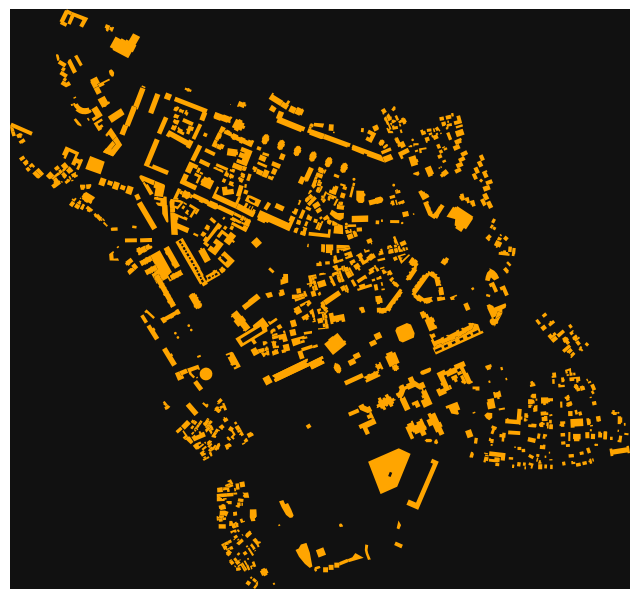

(<Figure size 800x800 with 1 Axes>, <AxesSubplot: >)

In [5]:
ox.plot_footprints(df_residential)

In [17]:
def calculate_max_ds(centroid, features):
    min_dist = features.apply(lambda feature: ox.distance.great_circle_vec(centroid.x, centroid.y, feature.x, feature.y)).min()
    min_time = min_dist / WALKING_SPEED_MS / 60

    if min_time > 25:
        return 0

    return min((25 - min_time) / 20, 1)

def calculate_lcs(node):
    total_score = 0
    center = node['geometry'].centroid

    for score, df in df_amenities:
        total_score += score * calculate_max_ds(center, df)

    return total_score

In [18]:
df_residential['lsc'] = df_residential.apply(calculate_lcs, axis=1)

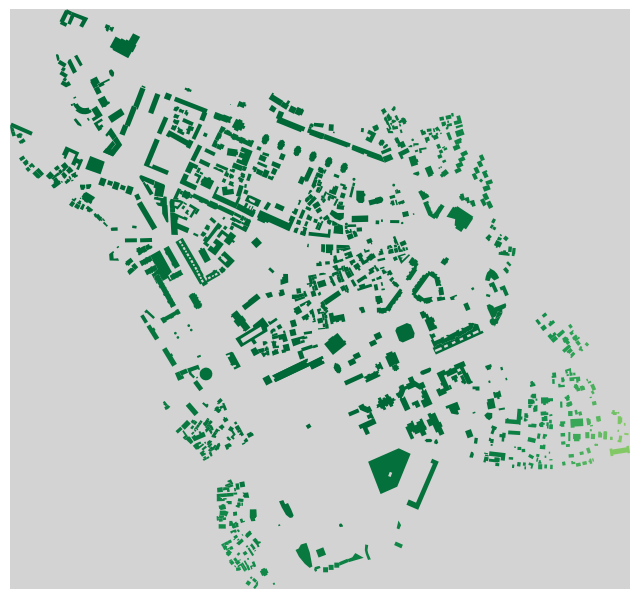

(<Figure size 800x800 with 1 Axes>, <AxesSubplot: >)

In [19]:
cmap = mpl.colormaps['RdYlGn']
ox.plot_footprints(df_residential, color=cmap((df_residential['lsc'] * 1.0 / df_residential['lsc'].max())), bgcolor='lightgrey')


<AxesSubplot: >

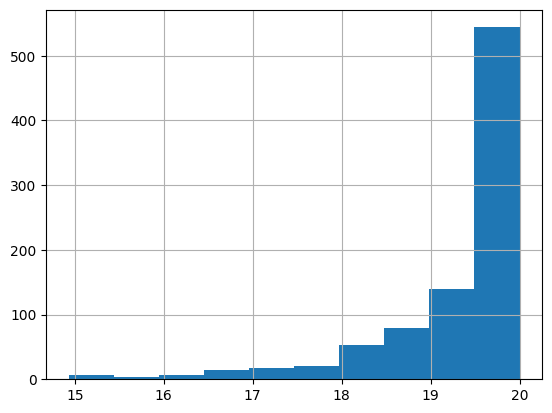

In [20]:
df_residential['lsc'].hist()

In [116]:
cmap(56)

(0.9637831603229527, 0.47743175701653207, 0.28581314878892733, 1.0)

<AxesSubplot: >

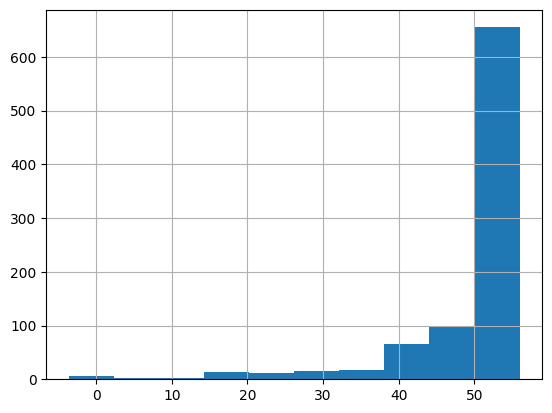

In [117]:
((sample['lsc'] / sample['lsc'].max()) * 256 - 200).hist()

In [129]:
cmap((df_residential['lsc'] / df_residential['lsc'].max()) * 256 - 200)[0]

array([0.        , 0.40784314, 0.21568627, 1.        ])

In [133]:
(df_residential['lsc'] / df_residential['lsc'].max()) * 256 - 200

0      56.000000
1      56.000000
2      56.000000
3      54.814371
4      53.273883
         ...    
881    56.000000
882    56.000000
883    56.000000
884    51.953428
885    56.000000
Name: lsc, Length: 886, dtype: float64

In [16]:
len(df_amenities)

9